# A short example of how to generate data and use functional k-means

## Author
Daniel Perdices <daniel.perdices at uam.es>

## Imports

In [7]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt; 
import seaborn as sns; sns.set(style="ticks", color_codes=True)
from pandas import DataFrame
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans as km
from sklearn.metrics import silhouette_score
import fda
from typing import Callable
from matplotlib import rc
plt.style.use('ggplot')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Generating the data

In [8]:
X = np.linspace(0,1,150) # time grid
N = 360 # number of curves

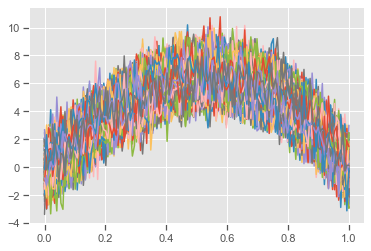

In [9]:
firstC = 30*(1-X)*np.power(X, 1.2) 
firstC = fda.FData(firstC, X)
k1 = lambda s,t: 0.2 * np.exp(-np.abs(s-t) / 0.3)
firstC.plt()
GP1 = fda.GaussianProcess(firstC, k1)
samples1 = GP1.generateSamples(N)
[c.plt() for c in samples1];

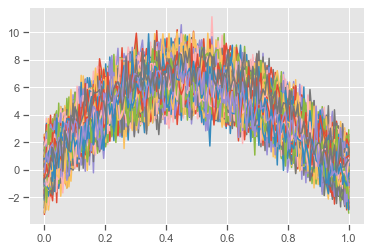

In [10]:
secondC = np.asarray(30*X*np.power((1-X), 1.2))
secondC = fda.FData(secondC, X)
secondC.plt()
GP2 = fda.GaussianProcess(secondC, k1)
samples2 = GP2.generateSamples(N)
[c.plt() for c in samples2];

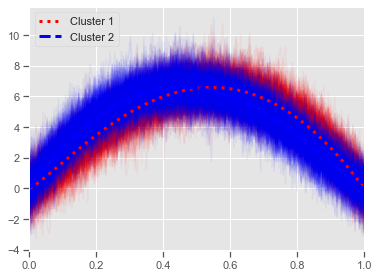

In [11]:
from scipy.stats import bernoulli
classes = bernoulli.rvs(0.85, size=N)
curves = [f if theta == 1 else g for theta, f, g in zip(classes, samples1, samples2)]
[c.plt(color="red", alpha=0.05) for c in samples1] + [c.plt(color="blue", alpha=0.05) for c in samples2];
ln1 = GP1.mean.plt(color="red", linestyle=":", linewidth=3)
ln2 = GP2.mean.plt(color="blue", linestyle="--", linewidth=3)
plt.legend([ln1[0], ln2[0]], ["Cluster 1", "Cluster 2"]);
plt.xlim([0,1]);
plt.grid(True)


## K-Means

Accuracy 0.9555555555555556
F-score 0.9734219269102989
distancia L2: 0.9831258450167915 1.0496217454393633
distancia L1: 0.7909391878361963 0.8266028923094862


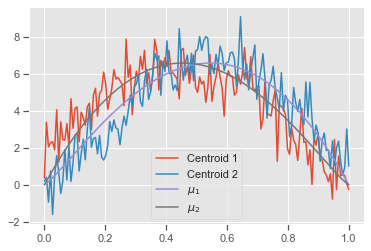

In [12]:
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split

train, test = train_test_split(curves, test_size=0.25)
colors = ["red", "green", "blue"]
kmeans = fda.KMeans(k=2, distance=fda.L2distance, depth_f=fda.deepest)
kmeans.train(train, iters=20)
[c.plt() for c in kmeans.centroids];
GP1.mean.plt();
GP2.mean.plt();
plt.legend([f"Centroid {i+1}" for i in range(kmeans.k)] + ["$\mu_1$", "$\mu_2$"])
d1 = min(fda.L2distance(GP1.mean, kmeans.centroids[0]), fda.L2distance(GP1.mean, kmeans.centroids[1]))
d2 = min(fda.L2distance(GP2.mean, kmeans.centroids[0]), fda.L2distance(GP2.mean, kmeans.centroids[1]))
l1d1 = min(fda.L1distance(GP1.mean, kmeans.centroids[0]), fda.L1distance(GP1.mean, kmeans.centroids[1]))
l1d2 = min(fda.L1distance(GP2.mean, kmeans.centroids[0]), fda.L1distance(GP2.mean, kmeans.centroids[1]))
mal_clas = np.sum(np.abs(kmeans.closest_centroid(curves) - classes))
mal_clas = min(mal_clas, len(curves) - mal_clas)
acc = max(accuracy_score(kmeans.closest_centroid(curves), classes), accuracy_score(kmeans.closest_centroid(curves), [0 if i == 1 else 1 for i in classes]))
fscore = max(f1_score(kmeans.closest_centroid(curves), classes), f1_score(kmeans.closest_centroid(curves), [0 if i == 1 else 1 for i in classes]))
print(f"Accuracy {acc}")
print(f"F-score {fscore}")
print(f"distancia L2: {d1} {d2}")
print(f"distancia L1: {l1d1} {l1d2}")